<a href="https://colab.research.google.com/github/Jshana01/blank-app/blob/main/AI_BERT_MODEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install transformers datasets torch scikit-learn
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension
!pip install contractions

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.9/113.9 kB 11.2 MB/s eta 0:00:00


In [4]:
import pandas as pd
import re
import contractions
import torch
import string
import nltk
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

In [5]:
# NLTK tools for cleaning
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [6]:
df = pd.read_csv(r"/content/McDonald_s_Reviews.csv", encoding='cp1252')

df.shape

df.info()

# STEP 1: CLEAN THE DATA IMPORTED

df = df[['review', 'rating']].dropna()

# Initialize stopwords and lemmatizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re, string, contractions

# Clean text function
def clean_text(text, apply_spell_correction=False):
    # Initialize lemmatizer and stopwords
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    # Fix contractions
    text = contractions.fix(str(text))
    # Remove non-ascii chars
    text = text.encode('ascii', errors='ignore').decode()
    # Remove punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    # Lowercase
    text = text.lower()
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Tokenize
    words = word_tokenize(text)
    # Optional spell correction
    if apply_spell_correction:
        from textblob import TextBlob
        words = [str(TextBlob(word).correct()) for word in words]
    # Remove stopwords and lemmatize
    cleaned_words = [lemmatizer.lemmatize(word) for word in words
                     if word not in stop_words and len(word) > 1]
    return ' '.join(cleaned_words)

# Apply cleaning
df['cleaned_review'] = df['review'].apply(clean_text)

# Remove empty cleaned reviews
df = df[df['cleaned_review'].str.strip() != '']
df = df.dropna(subset=['cleaned_review'])

# Convert rating like '4 stars' to integer
df['rating'] = df['rating'].astype(str).str.extract('(\d+)').astype(int)

# Add sentiment based on rating
def to_sentiment(r):
    if r <= 2:
        return "negative"
    elif r >= 3:
        return "positive"

df['sentiment'] = df['rating'].apply(to_sentiment)

# NEW: SAVE CLEANED DATA
df.to_csv(r"/content/cleaned_reviews_with_sentiment.csv", index=False)

print("✅ Cleaned dataset saved to cleaned_reviews_with_sentiment.csv")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33396 entries, 0 to 33395
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   reviewer_id    33396 non-null  int64  
 1   store_name     33396 non-null  object 
 2   category       33396 non-null  object 
 3   store_address  33396 non-null  object 
 4   latitude       32736 non-null  float64
 5   longitude      32736 non-null  float64
 6   rating_count   33396 non-null  object 
 7   review_time    33396 non-null  object 
 8   review         33396 non-null  object 
 9   rating         33396 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 2.5+ MB
✅ Cleaned dataset saved to cleaned_reviews_with_sentiment.csv


In [7]:
# Prepare data for model training

data = df[['cleaned_review', 'sentiment']].copy()
data = data.rename(columns={'cleaned_review': 'text'})

# Convert sentiment labels to numeric
label_map = {'negative': 0, 'positive': 1}
data['label'] = data['sentiment'].map(label_map)


In [8]:
# Step 3: Train/Test Split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['text'].tolist(), data['label'].tolist(), test_size=0.2, random_state=42
)

In [9]:
# Step 4: Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128, return_tensors='pt')
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128, return_tensors='pt')


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [10]:
# Step 5: Torch Dataset
class ReviewDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = ReviewDataset(train_encodings, train_labels)
test_dataset = ReviewDataset(test_encodings, test_labels)


In [11]:
# Step 6: Load Model & Optimizer
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
optimizer = AdamW(model.parameters(), lr=5e-5)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [12]:
# Step 7: Training data using BERT model
from torch.utils.data import DataLoader

# Use smaller batch size if GPU memory is low
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

model.train()
epochs = 2  # Lower for quick testing

for epoch in range(epochs):
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=True)
    total_loss = 0.0

    for step, batch in enumerate(loop):
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(**batch)
        loss = outputs.loss

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Print loss only every 50 steps to avoid slowing training
        if (step + 1) % 50 == 0 or (step + 1) == len(train_loader):
            loop.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} finished. Average Loss: {avg_loss:.4f}")



Epoch 1/2:   0%|          | 0/1662 [00:00<?, ?it/s]

Epoch 1 finished. Average Loss: 0.3028


Epoch 2/2:   0%|          | 0/1662 [00:00<?, ?it/s]

Epoch 2 finished. Average Loss: 0.2236


In [29]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate on training data
train_loader_eval = DataLoader(train_dataset, batch_size=16)
model.eval()
train_preds, train_labels_actual = [], []

with torch.no_grad():
    for batch in train_loader_eval:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        train_preds += torch.argmax(logits, dim=1).tolist()
        train_labels_actual += batch['labels'].tolist()

print("\n*** BERT Model Result Based On Train Data***")
print(classification_report(train_labels_actual, train_preds, target_names=['Negative', 'Positive']))

# Confusion matrix
conf_matrix_train = confusion_matrix(train_labels_actual, train_preds)
print("Confusion Matrix:")
print(conf_matrix_train)




*** BERT Model Result Based On Train Data***
              precision    recall  f1-score   support

    Negative       0.96      0.89      0.92     10022
    Positive       0.94      0.98      0.96     16570

    accuracy                           0.94     26592
   macro avg       0.95      0.93      0.94     26592
weighted avg       0.95      0.94      0.94     26592

Confusion Matrix:
[[ 8903  1119]
 [  362 16208]]


In [30]:
# Step 8: evaluation (test data)
model.eval()
test_loader = DataLoader(test_dataset, batch_size=16)
preds, labels = [], []

with torch.no_grad():
    for batch in tqdm(test_loader):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds += torch.argmax(logits, dim=1).tolist()
        labels += batch['labels'].tolist()

print("\n*** BERT Model Result Based On Test Data***")
print(classification_report(labels, preds, target_names=['Negative', 'Positive']))

# Confusion matrix for test data
conf_matrix_test = confusion_matrix(labels, preds)
print("Confusion Matrix:")
print(conf_matrix_test)




  0%|          | 0/416 [00:00<?, ?it/s]


*** BERT Model Result Based On Test Data***
              precision    recall  f1-score   support

    Negative       0.91      0.81      0.85      2439
    Positive       0.89      0.95      0.92      4209

    accuracy                           0.90      6648
   macro avg       0.90      0.88      0.89      6648
weighted avg       0.90      0.90      0.90      6648

Confusion Matrix:
[[1966  473]
 [ 206 4003]]


In [27]:
def predict_sentiment(text):
    model.eval()
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        prediction = torch.argmax(outputs.logits, dim=1).item()
    return 'Positive 😊' if prediction == 1 else 'Negative 😠'

# Example
predict_sentiment("best fries in the world")


'Positive 😊'

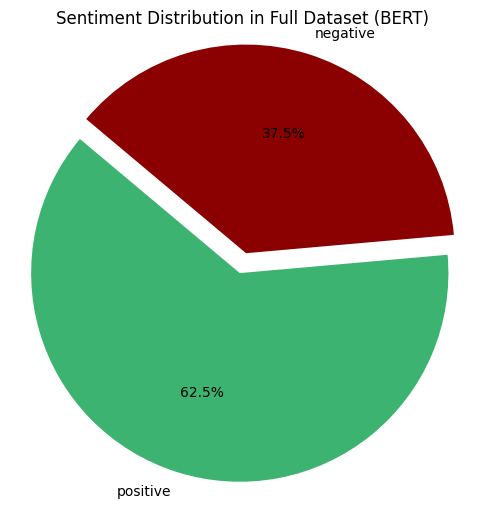

In [28]:
# Sentiment distribution pie chart for BERT dataset
sentiment_counts = data['sentiment'].value_counts()  # or df['sentiment'] if df still exists
labels = sentiment_counts.index
sizes = sentiment_counts.values
colors = ['#3CB371', '#8B0000']  # Positive = green, Negative = red
explode = (0.05, 0.05)  # Slight separation for slices

plt.figure(figsize=(6,6))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    colors=colors,
    explode=explode,
    startangle=140
)
plt.title('Sentiment Distribution in Full Dataset (BERT)')
plt.axis('equal')  # Keeps pie chart circular
plt.show()
